In [1]:
import numpy as np
import pylab as plt
import scipy.stats

from astroML.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


Hubble diagram for Type Ia supernovae

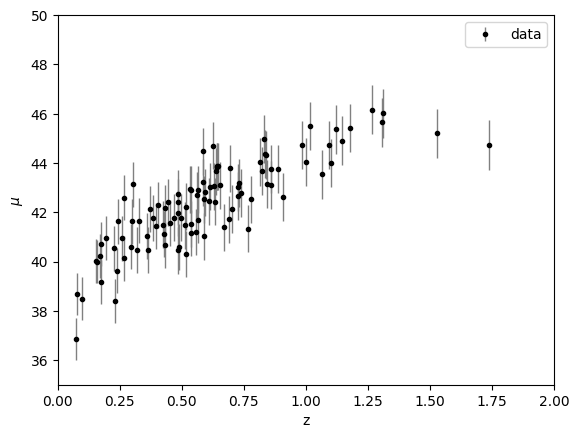

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

In [3]:
x = z_sample[:,np.newaxis]
y = mu_sample
dy = dmu

## Quick global fit

In [4]:
x_grid = np.linspace(0,2,1000)[:,np.newaxis]

### Linear regression 

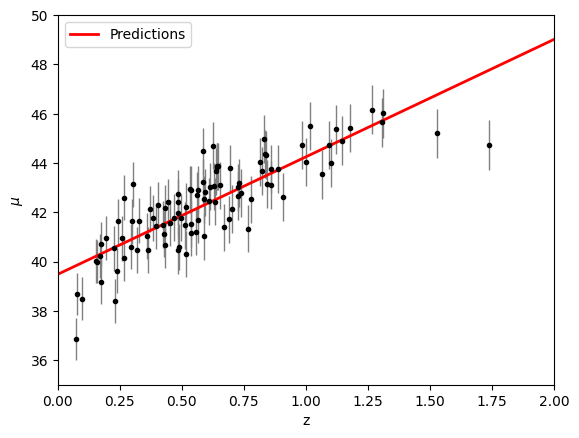

In [5]:
lin_reg = LinearRegression()
lin_reg.fit(x, mu_sample, dmu)

x_new_lin = np.array([[0], [2]])
y_pred_lin = lin_reg.predict(x_new_lin)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.plot(x_new_lin, y_pred_lin, "r", linewidth=2, label="Predictions")
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

### Polynomial regression

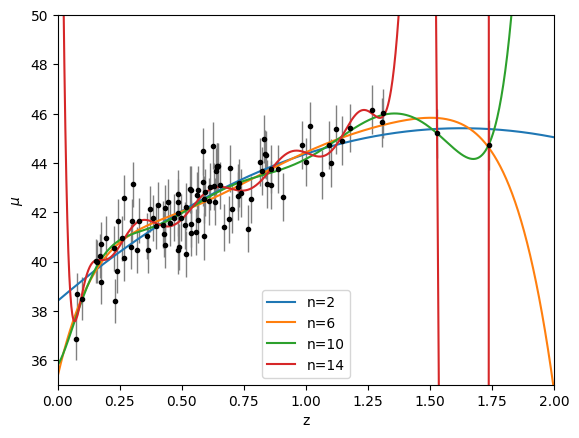

In [6]:
n_pol = np.arange(1,16)[1::4]

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

for n in n_pol:
    model = PolynomialRegression(n)
    model.fit(x, mu_sample, dmu)
    y_pred_pol = model.predict(x_grid)
    plt.plot(x_grid, y_pred_pol, label='n='+str(n))

plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

### Basis regression

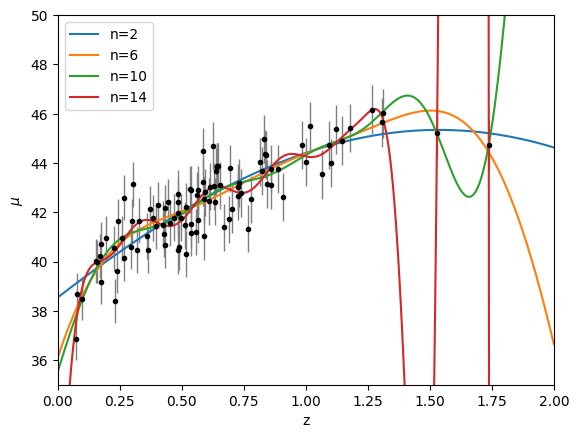

In [7]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

for n in np.arange(1,16)[1::4]:
    basis_mu = np.linspace(0,2,n)[:, np.newaxis]
    basis_sigma = basis_mu[1] - basis_mu[0] # to ensure overlap between the gaussian basis

    model = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
    model.fit(x, mu_sample, dmu)

    y_pred = model.predict(x_grid)
    plt.plot(x_grid, y_pred, label='n='+str(n))

plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

### Kernel regression

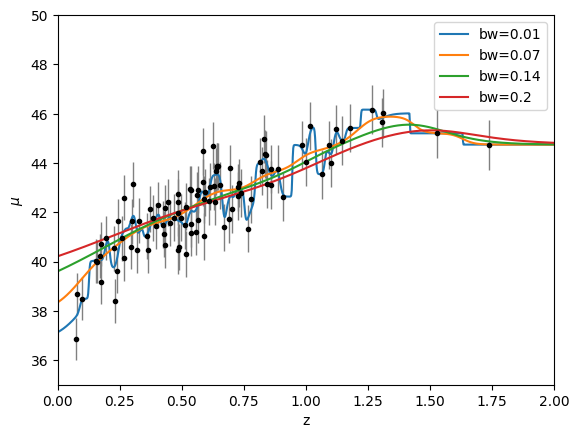

In [8]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

for bandwidth in np.round(np.linspace(0.01,0.2,4),2):
    model = NadarayaWatson('gaussian', bandwidth)
    model.fit(x,mu_sample)

    y_pred = model.predict(x_grid)
    plt.plot(x_grid, y_pred, label='bw='+str(bandwidth))

plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.legend()
plt.show()

## Cross validation

In [9]:
def err(X,y,classifier):
    return np.sqrt( np.sum( (y - classifier.predict(X))**2) / len(X) )

In [10]:
def fit_and_err(classifier):
    classifier.fit(X_train, y_train, dy_train)
    error_train = err(X_train,y_train,classifier)
    error_validation  = err(X_validation, y_validation, classifier)
    return error_train, error_validation

Split the dataset in train set and validation set

In [11]:
X_train, X_validation, y_train, y_validation, dy_train, dy_validation = train_test_split(x, y, dy, test_size=0.3, random_state=42)

#### Linear regression

In [12]:
classifier = LinearRegression()
err_train_lin, err_validation_lin = fit_and_err(classifier)

print("Training error = " + str(err_train_lin))
print("Validation error = " + str(err_validation_lin))

Training error = 1.048511599667497
Validation error = 0.8238924629073966


#### Polynomial regression

Best: 4
with validation error: 0.8095703348999922


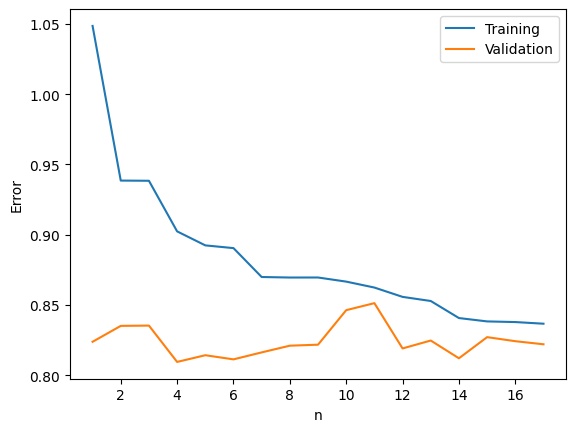

In [13]:
n_pol = np.arange(1,18)

err_train_pol = np.zeros(n_pol.size)
err_validation_pol = np.zeros(n_pol.size)

for idx, n in enumerate(n_pol):
    classifier = PolynomialRegression(n)
    err_train_pol[idx], err_validation_pol[idx] = fit_and_err(classifier)

best_n_pol = n_pol[np.argmin(err_validation_pol)]

print("Best: " + str( best_n_pol ))
print('with validation error: ' + str(min(err_validation_pol)))

plt.plot(n_pol, err_train_pol, label='Training')
plt.plot(n_pol, err_validation_pol, label='Validation')

plt.xlabel("n")
plt.ylabel("Error")
plt.legend()
plt.show()

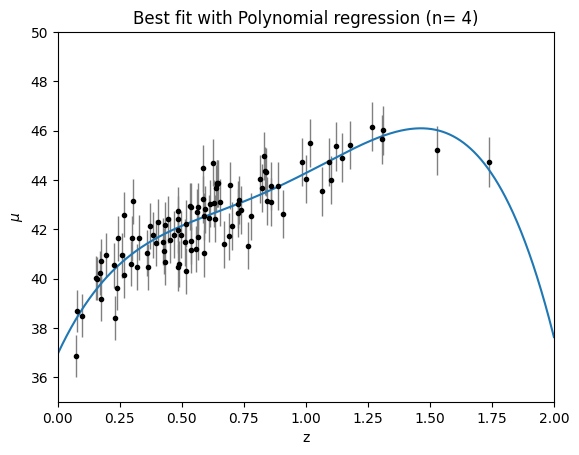

In [14]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

model = PolynomialRegression(best_n_pol)
model.fit(x, y, dy)
y_pred_pol = model.predict(x_grid)
plt.plot(x_grid, y_pred_pol)

plt.title('Best fit with Polynomial regression (n= ' +str(best_n_pol) + ')')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

#### Basis regression

Best: 13
with validation error: 0.8051058155715298


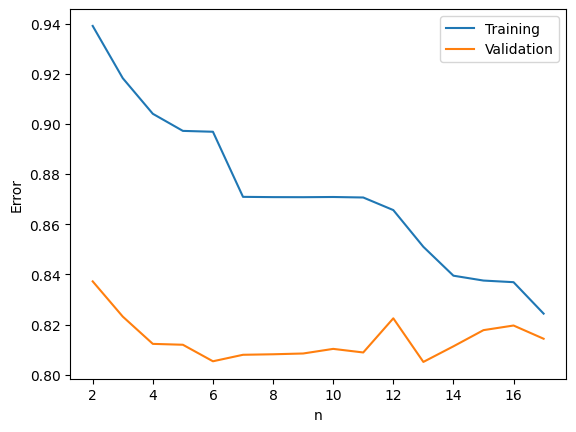

In [15]:
n_basis = np.arange(2,18)

err_train_basis = np.zeros(n_basis.size)
err_validation_basis = np.zeros(n_basis.size)

for idx, n in enumerate(n_basis):
    basis_mu = np.linspace(0,2,n)[:, np.newaxis]
    basis_sigma = basis_mu[1] - basis_mu[0]
    classifier = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
    err_train_basis[idx], err_validation_basis[idx] = fit_and_err(classifier)

best_n_basis = n_basis[np.argmin(err_validation_basis)] 

print("Best: " + str(best_n_basis))
print('with validation error: ' + str(min(err_validation_basis)))

plt.plot(n_basis, err_train_basis, label='Training')
plt.plot(n_basis, err_validation_basis, label='Validation')

plt.xlabel("n")
plt.ylabel("Error")
plt.legend()
plt.show()

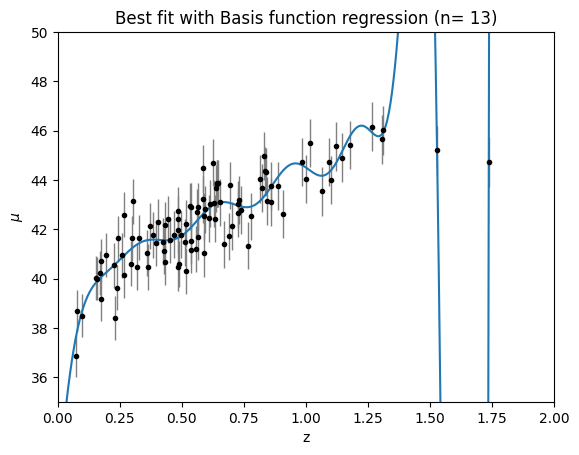

In [16]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

basis_mu = np.linspace(0,2,best_n_basis)[:, np.newaxis]
basis_sigma = basis_mu[1] - basis_mu[0] # to ensure overlap between the gaussian basis

model = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
model.fit(x, y, dy)

y_pred = model.predict(x_grid)
plt.plot(x_grid, y_pred)

plt.title('Best fit with Basis function regression (n= ' +str(best_n_basis) + ')')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

#### Kernel regression

Best: 0.05
with validation error: 0.7293555893180484


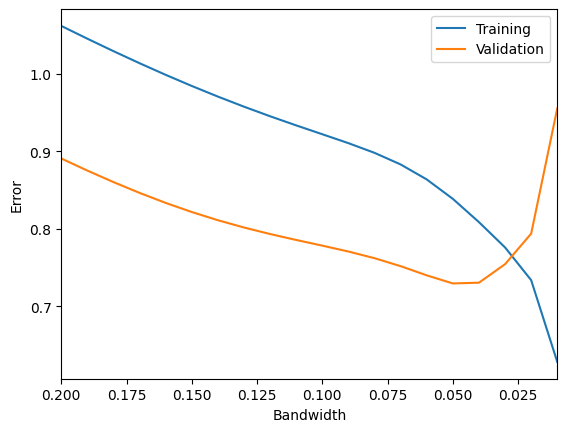

In [17]:
bandwidth = np.round(np.linspace(0.01,0.2,100),2)

err_train_kernel = np.zeros(bandwidth.size)
err_validation_kernel = np.zeros(bandwidth.size)

for idx, bw in enumerate(bandwidth):
    classifier = NadarayaWatson('gaussian', bw)
    err_train_kernel[idx], err_validation_kernel[idx] = fit_and_err(classifier)

best_bw = bandwidth[np.argmin(err_validation_kernel)]
print("Best: " + str(best_bw))
print('with validation error: ' + str(min(err_validation_kernel)))

plt.plot(bandwidth, err_train_kernel, label='Training')
plt.plot(bandwidth, err_validation_kernel, label='Validation')

plt.xlim(bandwidth[-1],bandwidth[0]) 
plt.xlabel("Bandwidth")
plt.ylabel("Error")
plt.legend()
plt.show()

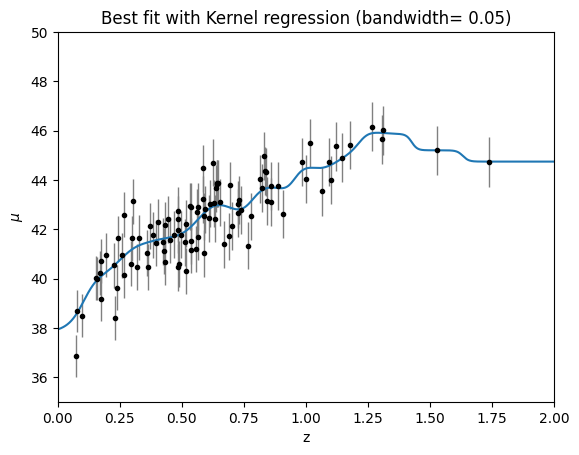

In [18]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

model = NadarayaWatson('gaussian', best_bw)
model.fit(x,y)

y_pred = model.predict(x_grid)
plt.plot(x_grid, y_pred)

plt.title('Best fit with Kernel regression (bandwidth= ' +str(best_bw) + ')')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Learning curves

In [19]:
scaler = StandardScaler()
Xscaled = scaler.fit_transform(x)

#### Linear regression

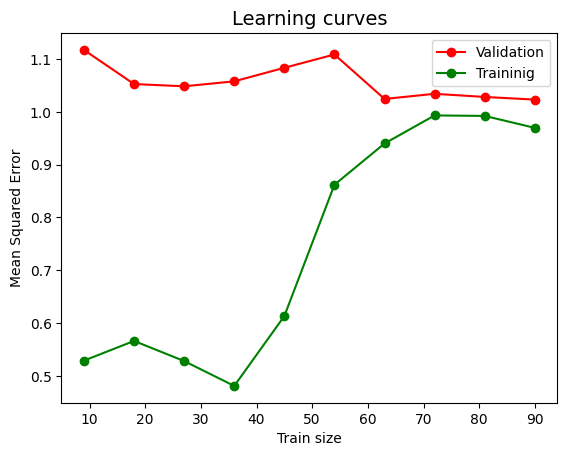

In [20]:
classifier = LinearRegression()

# Ten training sample sizes from 10% to 100%
train_sizes, train_scores_linreg, test_scores_linreg = \
    learning_curve(classifier, Xscaled, y, train_sizes=np.linspace(0.1, 1, 10), \
    scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_linreg.mean(1), 'o-', color="r", label="Validation")
plt.plot(train_sizes, -train_scores_linreg.mean(1), 'o-', color="g", label="Traininig")
                   
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves',fontsize=14)
plt.legend()
plt.show()

#### Polynomial regression

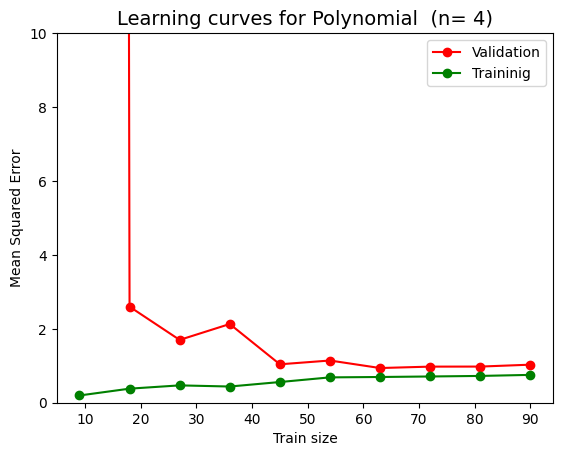

In [21]:
classifier = PolynomialRegression(best_n_pol)  # Search 

# Ten training sample sizes from 10% to 100%
train_sizes, train_scores_pol, test_scores_pol = \
    learning_curve(classifier, Xscaled, y, train_sizes=np.linspace(0.1, 1, 10), \
    scoring="neg_mean_squared_error", cv=10)

plt.plot(train_sizes, -test_scores_pol.mean(1), 'o-', color="r", label="Validation")
plt.plot(train_sizes, -train_scores_pol.mean(1), 'o-', color="g", label="Traininig")

plt.ylim(0,10)
plt.xlabel("Train size")
plt.ylabel("Mean Squared Error")
plt.title('Learning curves for Polynomial  (n= ' +str(best_n_pol) + ')',fontsize=14)
plt.legend()
plt.show()

We have enough data